In [ ]:
#hide
#default_exp tools.metric_visualization
from nbdev.showdoc import show_doc

# Metric visualization

> Visualize metrics collected from experiments.

In [ ]:
#export
import warnings
warnings.filterwarnings('ignore')

import argparse
import sys
sys.path.append('.')
sys.path.append('src')
import pandas as pd
import pickle
import hpsearch.visualization.experiment_visualization as ev
from hpsearch.config.hpconfig import get_path_experiments
from hpsearch.config.hpconfig import get_default_operations

def include_best_and_last_experiment (metrics, experiments=[-1, -2], root_folder=None, run_number=0, op='max'):
    for i in range(len(experiments)):
        if experiments[i] == -1:
            root_path = get_path_experiments (folder = root_folder)
            experiment_number = pickle.load(open(f'{root_path}/current_experiment_number.pkl','rb'))
            experiments[i] = experiment_number

        if experiments[i] == -2:
            first_metric = metrics[0]
            if len(metrics)>1:
                print (f'we use the first metric {first_metric} in given list {metrics} for obtaining the best experiment')
            root_path = get_path_experiments (folder = root_folder)
            df = pd.read_csv(f'{root_path}/experiments_data.csv',index_col=0)
            if op=='max':
                experiments[i] = df[f'{run_number}_{first_metric}'].idxmax()
            else:
                experiments[i] = df[f'{run_number}_{first_metric}'].idxmin()
                
    return experiments

def metric_visualization (experiments=[-1,-2], run_number=0, root_folder=None, metric=None, op = None,
                          parameters=None, name_file='model_history.pk', visualization_options = {},
                          backend='plotly'):
    
    default_operations = get_default_operations ()
    if root_folder is None:
        root_folder = default_operations.get('root', 'results')
    if metric is None:
        metric = default_operations.get('metric', 'accuracy')
    if op is None:
        op = default_operations.get('op', 'min')
        
    # metrics
    if type(metric) is str:
        metrics = [metric]
    else:
        metrics = metric
        
    experiments = include_best_and_last_experiment (metrics, experiments=experiments, root_folder=root_folder, 
                                                         run_number=run_number, op=op)
    
    if 'visualization' in visualization_options.keys():
        visualization = visualization_options.pop('visualization')
    else:
        visualization = 'history'
    
    ev.visualize_experiments(visualization=visualization, 
                             experiments=experiments, run_number=run_number, root_folder=root_folder,metrics=metrics, 
                             parameters=parameters, name_file=name_file, **visualization_options,
                             backend=backend)

def parse_args(args):
    parser = argparse.ArgumentParser(description='show metrics about experiments') 
    # Datasets
    parser.add_argument('-e', nargs='+', default=[-1, -2], type=int,
                        help="experiments")
    parser.add_argument('-m', '--metric', nargs='+', type=str, default=None, help="metrics")
    parser.add_argument('--root', type=str, default=None)
    parser.add_argument('-l','--labels',nargs='+', default=None, type=str)
    parser.add_argument('--run', default=0, type=int)
    parser.add_argument('--op', default=None, type=str)
    parser.add_argument('-b', '--backend', default='visdom', type=str)
    parser.add_argument('-f', '--file', default='model_history.pk', type=str)
    parser.add_argument('-v', '--visualization', default='{}', type=str)

    pars = parser.parse_args(args)
    
    pars.visualization = eval(pars.visualization)
    
    return pars

def parse_arguments_and_visualize (args):
    
    pars = parse_args(args)

    metric_visualization (pars.e, run_number=pars.run, root_folder=pars.root, metric=pars.metric, 
                          parameters=pars.labels, name_file=pars.file, backend=pars.backend, 
                          visualization_options=pars.visualization)
    
def main():

    parse_arguments_and_visualize (sys.argv[1:])



## Usage examples

### Produce data

In [ ]:
#collapse_output
from hpsearch.examples.dummy_experiment_manager import remove_previous_experiments, run_multiple_experiments

remove_previous_experiments()
run_multiple_experiments(nruns=5, noise=0.1)

experiment script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line: 205
processing hyper-parameter 0 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 0
run number: 0

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 205
time spent on this experiment: 0.0008969306945800781
0 - validation_accuracy: 0.13638819879291475
0 - test_accuracy: 0.4464950937888109
finished experiment 0
processing hyper-parameter 0 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 0
run number: 1

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 205
time spent on this experiment: 0.0009019374847412109
1 - validation_accuracy: 0.17616244343046417
1 - test_accuracy: 0.3044156866392609
finished experiment 0
processing hyper-para

using import method 1
using import method 1
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25


finished experiment 0
processing hyper-parameter 0 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 0
run number: 4

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 205
time spent on this experiment: 0.0010898113250732422
4 - validation_accuracy: 0.18269597904465093
4 - test_accuracy: 0.3934245039332182
finished experiment 0
processing hyper-parameter 1 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 1
run number: 0

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 205
time spent on this experiment: 0.0009832382202148438
0 - validation_accuracy: 0.505330310398155
0 - test_accuracy: 0.4467807595598265
finished experiment 1
processing hyper-parameter 1 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
runn

registering
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007


running experiment 1
run number: 3

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 205
time spent on this experiment: 0.000946044921875
3 - validation_accuracy: 0.4331058995532552
3 - test_accuracy: 0.5119232283557088
finished experiment 1
processing hyper-parameter 1 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 1
run number: 4

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 205
time spent on this experiment: 0.0008859634399414062
4 - validation_accuracy: 0.5327056526266345
4 - test_accuracy: 0.6518948432868887
finished experiment 1
processing hyper-parameter 2 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 2
run number: 0

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch

registering
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001


finished experiment 2
processing hyper-parameter 2 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 2
run number: 2

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 205
time spent on this experiment: 0.000919342041015625
2 - validation_accuracy: 0.6398263326716056
2 - test_accuracy: 0.9635609670190637
finished experiment 2
processing hyper-parameter 2 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 2
run number: 3

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 205
time spent on this experiment: 0.0009000301361083984
3 - validation_accuracy: 0.7035928284238732
3 - test_accuracy: 0.9127050946276278
finished experiment 2
processing hyper-parameter 2 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
runni

registering
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
registering
fitting model with 15 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accur

finished experiment 3
processing hyper-parameter 3 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 3
run number: 1

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 205
time spent on this experiment: 0.0022950172424316406
1 - validation_accuracy: 0.3726016046764908
1 - test_accuracy: 0.4342907290772157
finished experiment 3
processing hyper-parameter 3 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 3
run number: 2

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 205
time spent on this experiment: 0.001848459243774414
2 - validation_accuracy: 0.46964901777564644
2 - test_accuracy: 0.25355311873237785
finished experiment 3
processing hyper-parameter 3 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
r

registering
fitting model with 15 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13: accuracy: 0.5200000000000002
epoch 14: accuracy: 0.5500000000000003
registering
fitting model with 15 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13

finished experiment 3
processing hyper-parameter 4 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 4
run number: 0

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 205
time spent on this experiment: 0.002021312713623047
0 - validation_accuracy: 0.5465291910862597
0 - test_accuracy: 0.6208201271393949
finished experiment 4
processing hyper-parameter 4 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 4
run number: 1

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 205
time spent on this experiment: 0.0018568038940429688
1 - validation_accuracy: 0.6019699558153141
1 - test_accuracy: 0.578267838290984
finished experiment 4
processing hyper-parameter 4 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
runn

registering
fitting model with 15 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.5700000000000002
epoch 9: accuracy: 0.6000000000000002
epoch 10: accuracy: 0.6300000000000002
epoch 11: accuracy: 0.6600000000000003
epoch 12: accuracy: 0.6900000000000003
epoch 13: accuracy: 0.7200000000000003
epoch 14: accuracy: 0.7500000000000003
registering
fitting model with 15 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.5700000000000002
epoch 9: accuracy: 0.6000000000000002
epoch 10: acc

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 205
time spent on this experiment: 0.0022263526916503906
3 - validation_accuracy: 0.7985536286326137
3 - test_accuracy: 0.6313451066152833
finished experiment 4
processing hyper-parameter 4 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 4
run number: 4

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 205
time spent on this experiment: 0.0018701553344726562
4 - validation_accuracy: 0.8080205005200524
4 - test_accuracy: 0.7254935575004418
finished experiment 4
processing hyper-parameter 5 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 5
run number: 0

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 205
time spent on this experi

fitting model with 15 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.5700000000000002
epoch 9: accuracy: 0.6000000000000002
epoch 10: accuracy: 0.6300000000000002
epoch 11: accuracy: 0.6600000000000003
epoch 12: accuracy: 0.6900000000000003
epoch 13: accuracy: 0.7200000000000003
epoch 14: accuracy: 0.7500000000000003
registering
fitting model with 15 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.5700000000000002
epoch 9: accuracy: 0.6000000000000002
epoch 10: accuracy: 0.630

running experiment 5
run number: 2

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 205
time spent on this experiment: 0.0018763542175292969
2 - validation_accuracy: 1.0
2 - test_accuracy: 0.9473779057003792
finished experiment 5
processing hyper-parameter 5 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 5
run number: 3

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 205
time spent on this experiment: 0.00209808349609375
3 - validation_accuracy: 1.0
3 - test_accuracy: 0.6716838188475586
finished experiment 5
processing hyper-parameter 5 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 5
run number: 4

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_

fitting model with 15 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
epoch 5: accuracy: 0.7800000000000001
epoch 6: accuracy: 0.8100000000000002
epoch 7: accuracy: 0.8400000000000002
epoch 8: accuracy: 0.8700000000000002
epoch 9: accuracy: 0.9000000000000002
epoch 10: accuracy: 0.9300000000000003
epoch 11: accuracy: 0.9600000000000003
epoch 12: accuracy: 0.9900000000000003
epoch 13: accuracy: 1.0200000000000002
epoch 14: accuracy: 1.0500000000000003
registering
fitting model with 15 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
epoch 5: accuracy: 0.7800000000000001
epoch 6: accuracy: 0.8100000000000002
epoch 7: accuracy: 0.8400000000000002
epoch 8: accuracy: 0.8700000000000002
epoch 9: accuracy: 0.9000000000000002
epoch 10: accuracy: 0.930000000

running experiment 6
run number: 1

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 205
time spent on this experiment: 0.003452777862548828
1 - validation_accuracy: 0.50702343928058
1 - test_accuracy: 0.40327436664448
finished experiment 6
processing hyper-parameter 6 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 6
run number: 2

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 205
time spent on this experiment: 0.0039217472076416016
2 - validation_accuracy: 0.1704881057329853
2 - test_accuracy: 0.31790819825980926
finished experiment 6
processing hyper-parameter 6 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 6
run number: 3

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsea

fitting model with 30 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13: accuracy: 0.5200000000000002
epoch 14: accuracy: 0.5500000000000003
epoch 15: accuracy: 0.5800000000000003
epoch 16: accuracy: 0.6100000000000003
epoch 17: accuracy: 0.6400000000000003
epoch 18: accuracy: 0.6700000000000004
epoch 19: accuracy: 0.7000000000000004
epoch 20: accuracy: 0.6700000000000004
epoch 21: accuracy: 0.6400000000000003
epoch 22: accuracy: 0.6100000000000003
epoch 23: accuracy: 0.5800000000000003
epoch 24: accuracy: 0.5500000000000003
epoch 25: accuracy: 0.5200000000000002
epoch 26: accuracy: 0.4900000000000002
epoch 27:

running experiment 7
run number: 0

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 205
time spent on this experiment: 0.003390073776245117
0 - validation_accuracy: 0.6823712030824944
0 - test_accuracy: 0.5110956570681089
finished experiment 7
processing hyper-parameter 7 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 7
run number: 1

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 205
time spent on this experiment: 0.003454923629760742
1 - validation_accuracy: 0.47279289221969045
1 - test_accuracy: 0.5728139113369013
finished experiment 7
processing hyper-parameter 7 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 7
run number: 2

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hp

fitting model with 30 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.5700000000000002
epoch 9: accuracy: 0.6000000000000002
epoch 10: accuracy: 0.6300000000000002
epoch 11: accuracy: 0.6600000000000003
epoch 12: accuracy: 0.6900000000000003
epoch 13: accuracy: 0.7200000000000003
epoch 14: accuracy: 0.7500000000000003
epoch 15: accuracy: 0.7800000000000004
epoch 16: accuracy: 0.8100000000000004
epoch 17: accuracy: 0.8400000000000004
epoch 18: accuracy: 0.8700000000000004
epoch 19: accuracy: 0.9000000000000005
epoch 20: accuracy: 0.8700000000000004
epoch 21: accuracy: 0.8400000000000004
epoch 22: accuracy: 0.8100000000000004
epoch 23: accuracy: 0.7800000000000004
epoch 24: accuracy: 0.7500000000000003
epoch 25: accuracy: 0.720000000

finished experiment 7
processing hyper-parameter 7 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 7
run number: 4

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 205
time spent on this experiment: 0.0033032894134521484
4 - validation_accuracy: 0.4941700858954303
4 - test_accuracy: 0.4642860562436247
finished experiment 7
processing hyper-parameter 8 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 8
run number: 0

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 205
time spent on this experiment: 0.0038394927978515625
0 - validation_accuracy: 0.8140833079651094
0 - test_accuracy: 0.8801687149697123
finished experiment 8
processing hyper-parameter 8 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
ru

registering
fitting model with 30 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.5700000000000002
epoch 9: accuracy: 0.6000000000000002
epoch 10: accuracy: 0.6300000000000002
epoch 11: accuracy: 0.6600000000000003
epoch 12: accuracy: 0.6900000000000003
epoch 13: accuracy: 0.7200000000000003
epoch 14: accuracy: 0.7500000000000003
epoch 15: accuracy: 0.7800000000000004
epoch 16: accuracy: 0.8100000000000004
epoch 17: accuracy: 0.8400000000000004
epoch 18: accuracy: 0.8700000000000004
epoch 19: accuracy: 0.9000000000000005
epoch 20: accuracy: 0.8700000000000004
epoch 21: accuracy: 0.8400000000000004
epoch 22: accuracy: 0.8100000000000004
epoch 23: accuracy: 0.7800000000000004
epoch 24: accuracy: 0.7500000000000003
epoch 25: accuracy:

running experiment 8
run number: 2

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 205
time spent on this experiment: 0.0034046173095703125
2 - validation_accuracy: 0.9310962530673567
2 - test_accuracy: 0.8463395754259104
finished experiment 8
processing hyper-parameter 8 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 8
run number: 3

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 205
time spent on this experiment: 0.003258228302001953
3 - validation_accuracy: 0.8248371869849092
3 - test_accuracy: 0.8924255917887114
finished experiment 8
processing hyper-parameter 8 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 8
run number: 4

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hp

fitting model with 30 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
epoch 5: accuracy: 0.7800000000000001
epoch 6: accuracy: 0.8100000000000002
epoch 7: accuracy: 0.8400000000000002
epoch 8: accuracy: 0.8700000000000002
epoch 9: accuracy: 0.9000000000000002
epoch 10: accuracy: 0.9300000000000003
epoch 11: accuracy: 0.9600000000000003
epoch 12: accuracy: 0.9900000000000003
epoch 13: accuracy: 1.0200000000000002
epoch 14: accuracy: 1.0500000000000003
epoch 15: accuracy: 1.0800000000000003
epoch 16: accuracy: 1.1100000000000003
epoch 17: accuracy: 1.1400000000000003
epoch 18: accuracy: 1.1700000000000004
epoch 19: accuracy: 1.2000000000000004
epoch 20: accuracy: 1.1700000000000004
epoch 21: accuracy: 1.1400000000000003
epoch 22: accuracy: 1.1100000000000003
epoch 23: accuracy: 1.0800000000000003
epoch 24: accuracy: 1.0500000000000003
epoch 25: accuracy: 1.020000000000

In [ ]:
metric_visualization()

,epochs,validation_accuracy
8,30.0,1.0
5,15.0,1.0


In [ ]:
metric_visualization(experiments=[-2, 0], metric='test_accuracy')

,offset,test_accuracy
2,0.6,0.855533
0,0.1,0.316901


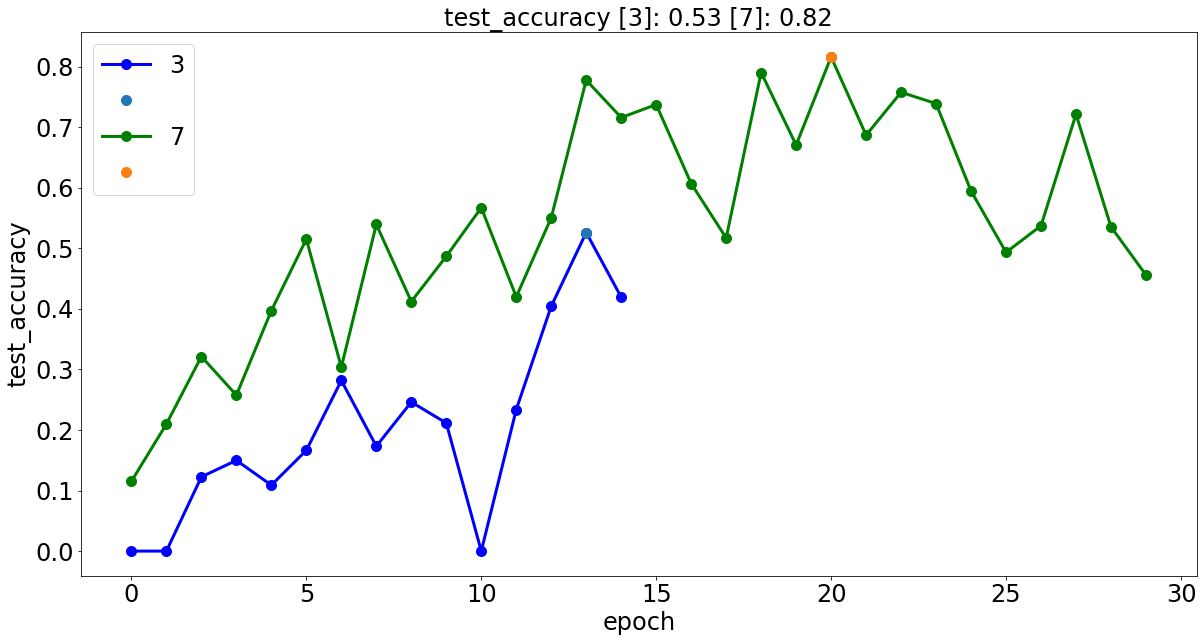

,epochs,offset,test_accuracy
3,15.0,0.1,0.526250
7,30.0,0.3,0.816316


In [ ]:
metric_visualization(experiments=[3, 7], metric='test_accuracy', backend='matplotlib')

## Using more than one visualization routine

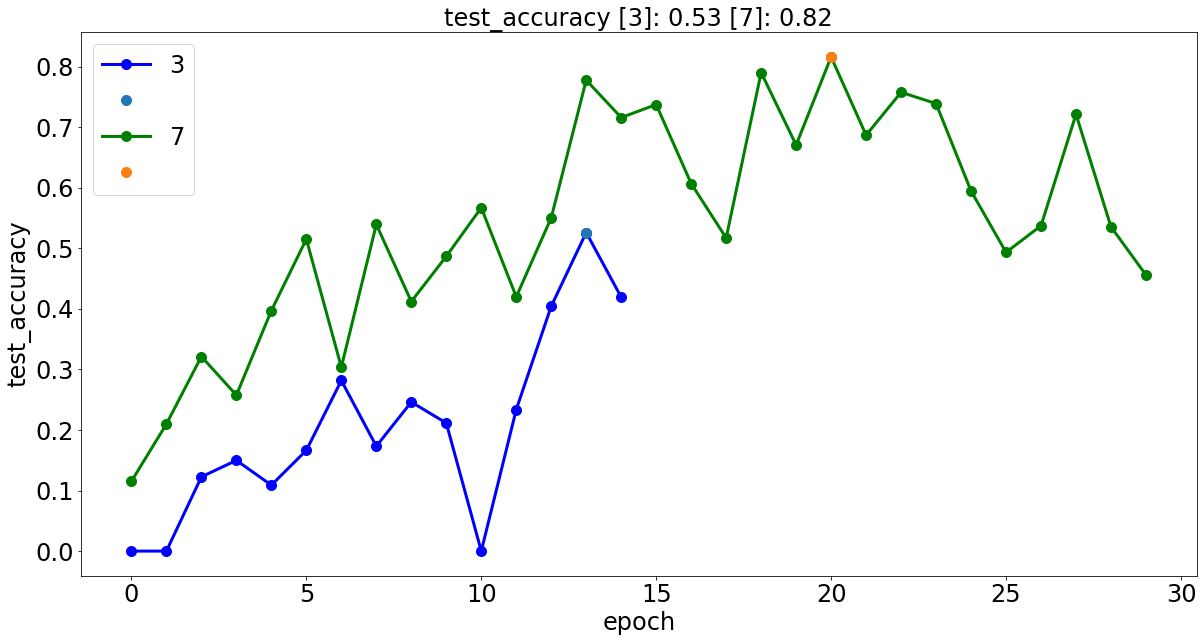

,epochs,offset,test_accuracy
3,15.0,0.1,0.526250
7,30.0,0.3,0.816316


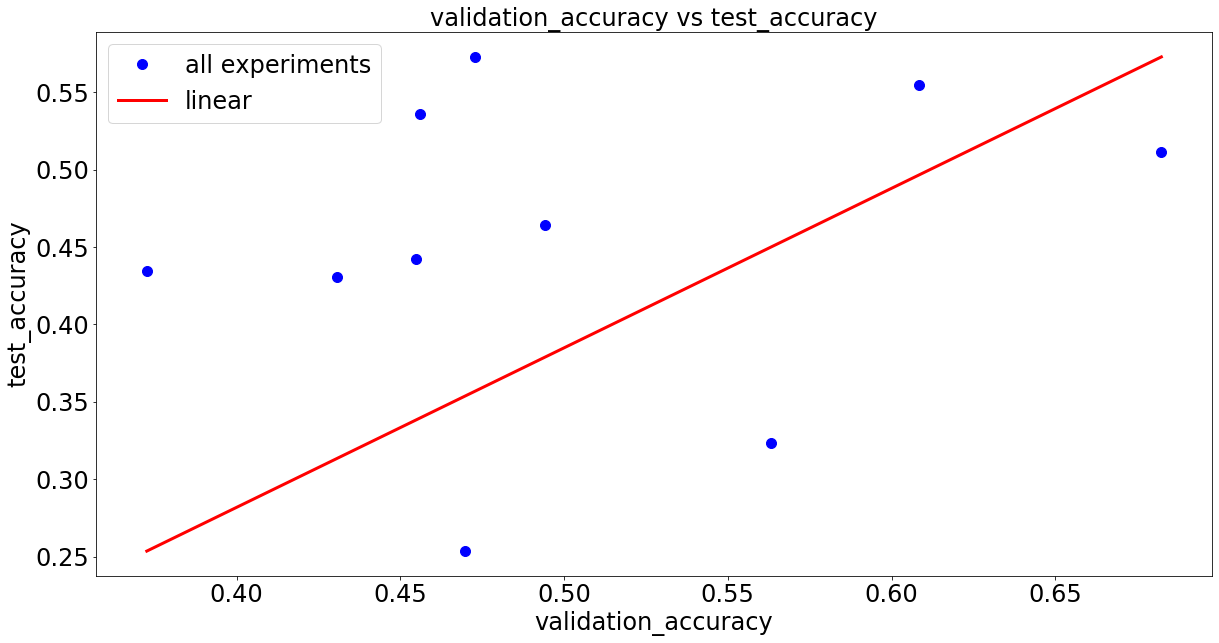

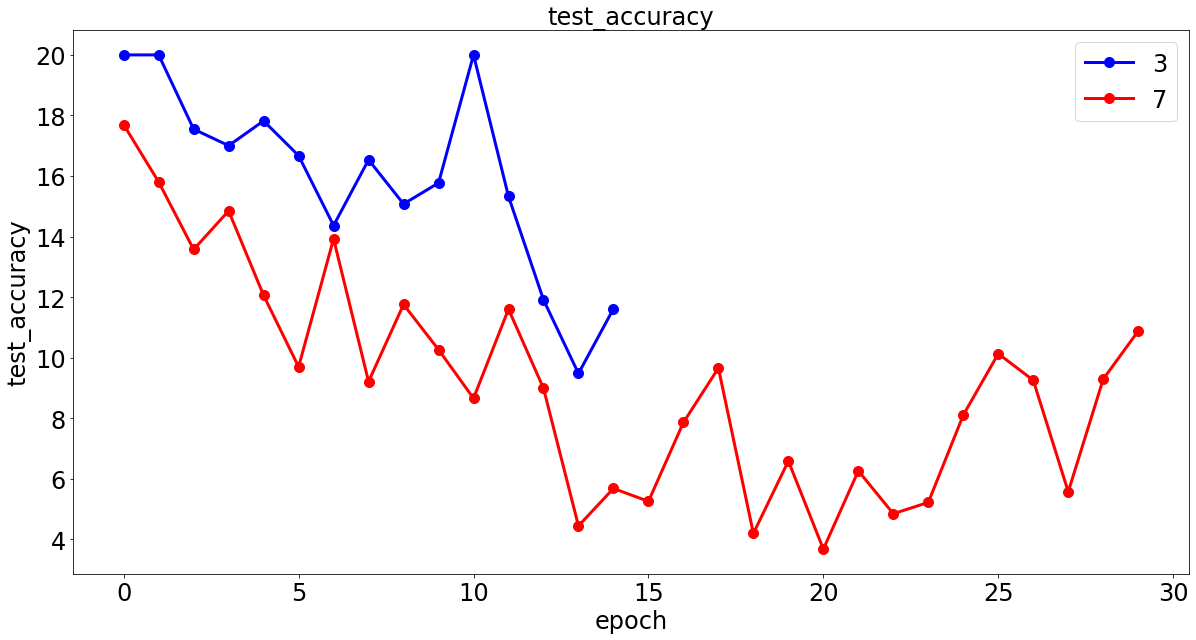

In [ ]:
metric_visualization(experiments=[3, 7], metric='test_accuracy', backend='matplotlib', 
                     visualization_options={'visualization': ['history', 'metric_correlation', 'custom'],
                                           'metric_1': 'validation_accuracy',
                                            'metric_2': 'test_accuracy'})

Test the command line parser

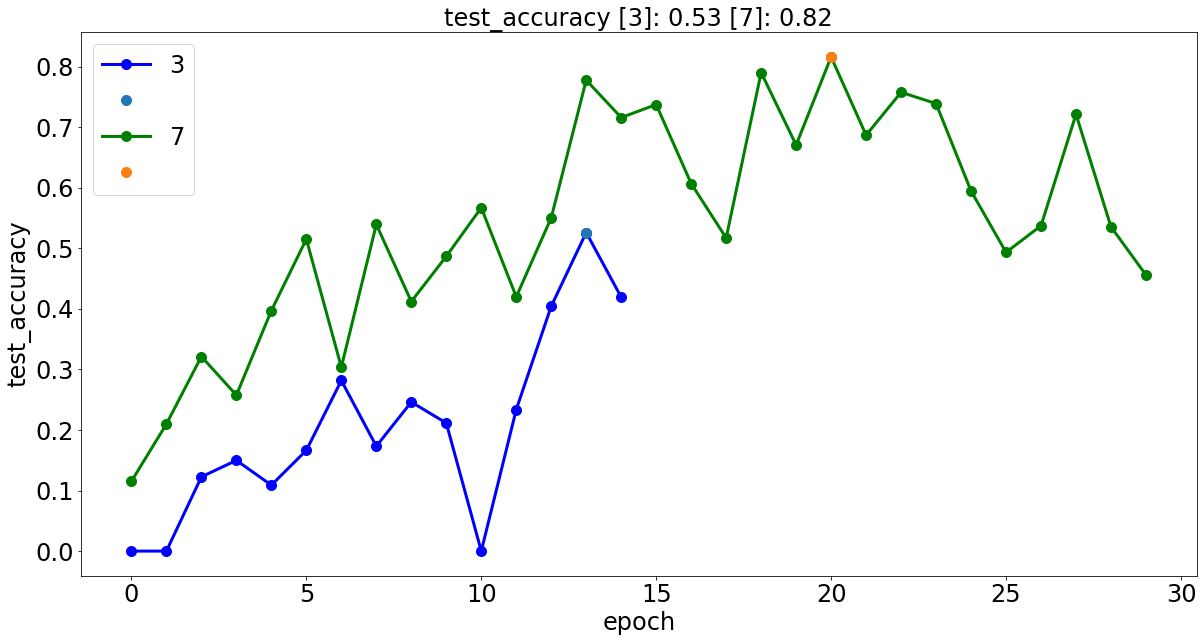

,epochs,offset,test_accuracy
3,15.0,0.1,0.526250
7,30.0,0.3,0.816316


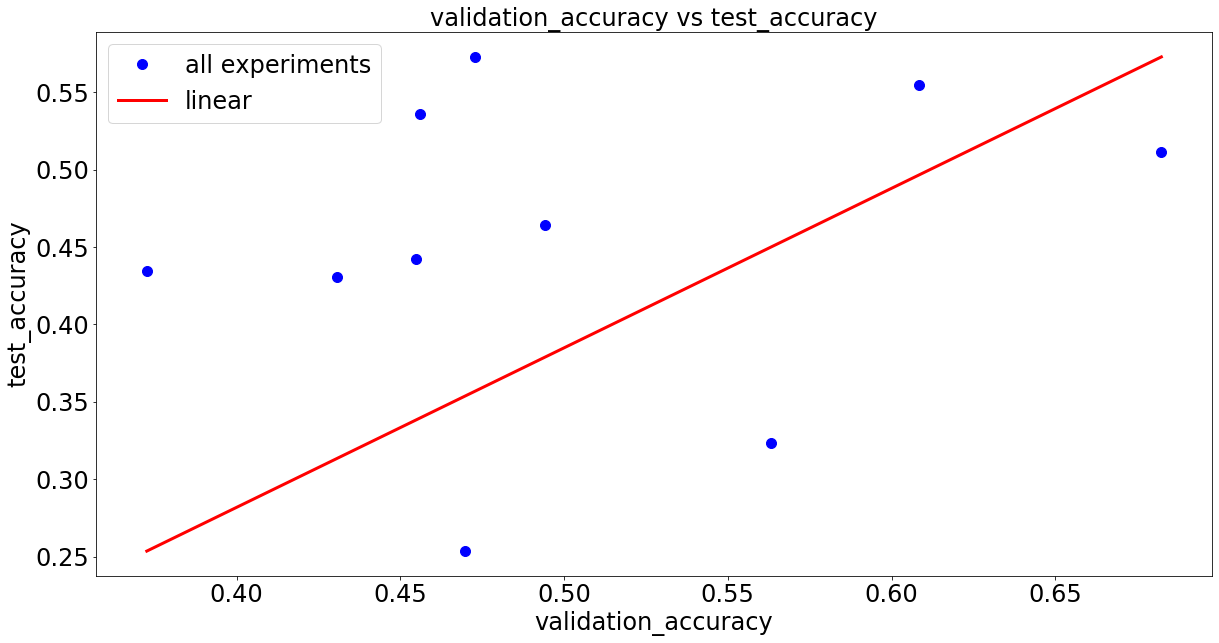

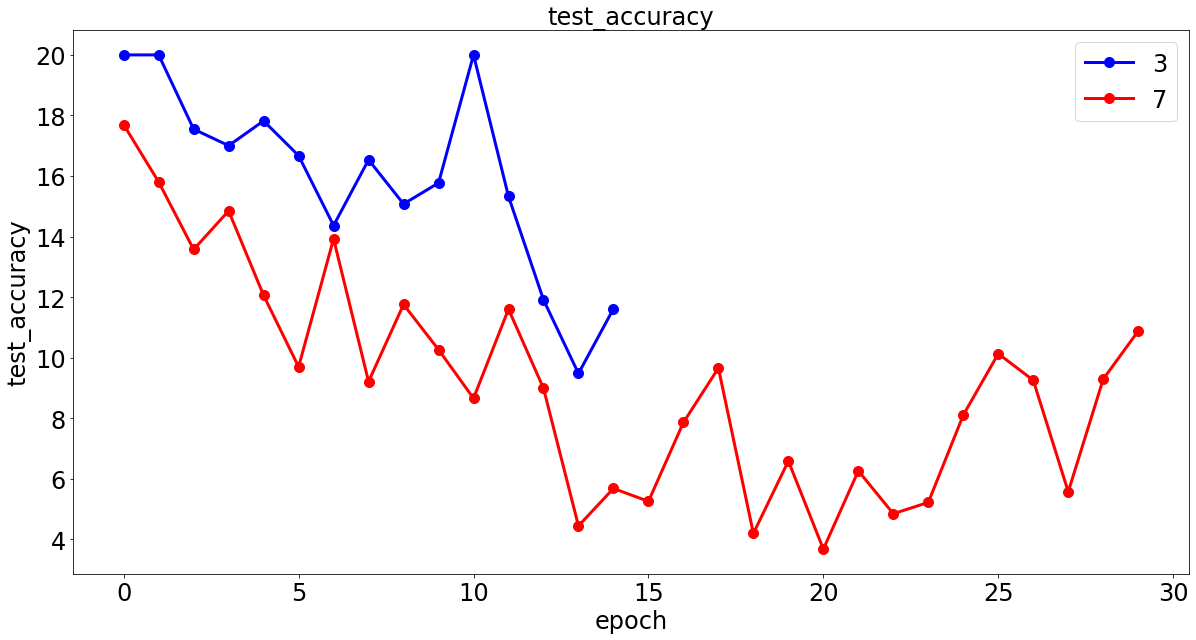

In [ ]:
parse_arguments_and_visualize (['-e', '3', '7', 
                                '-m', 'test_accuracy', 
                                '-b', 'matplotlib', 
                                '-v', '{"visualization": ["history", "metric_correlation", "custom"], "metric_1": "validation_accuracy", "metric_2": "test_accuracy"}'])

### Visualize more than one metric

we use the first metric test_accuracy in given list ['test_accuracy', 'validation_accuracy'] for obtaining the best experiment


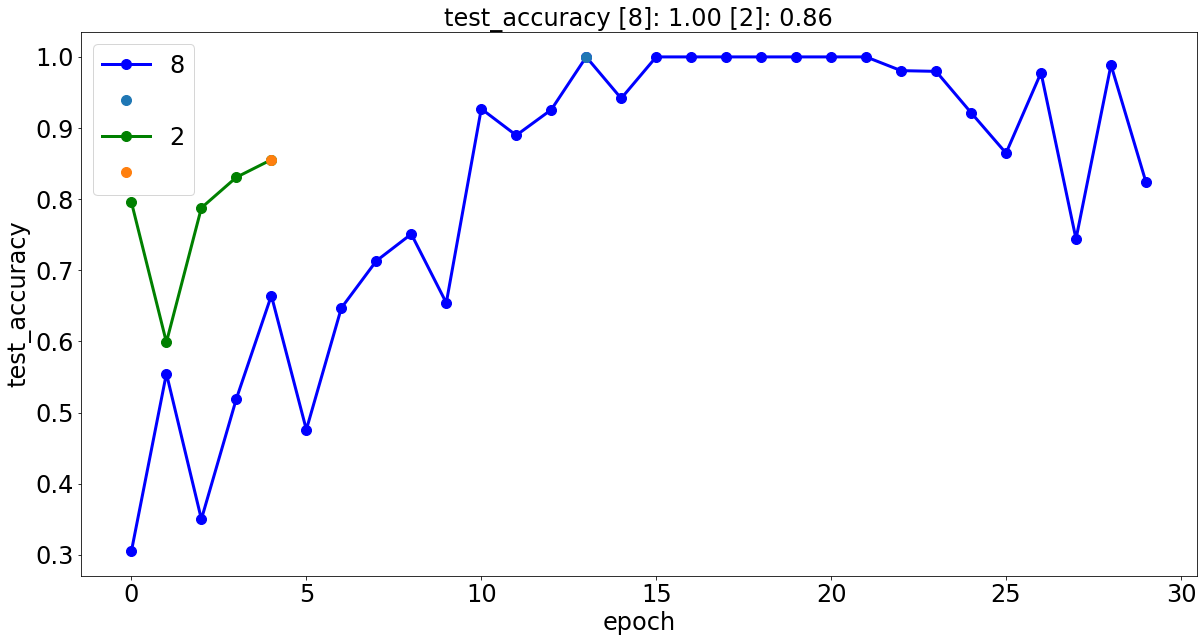

,epochs,test_accuracy
8,30.0,1.000000
2,5.0,0.855533


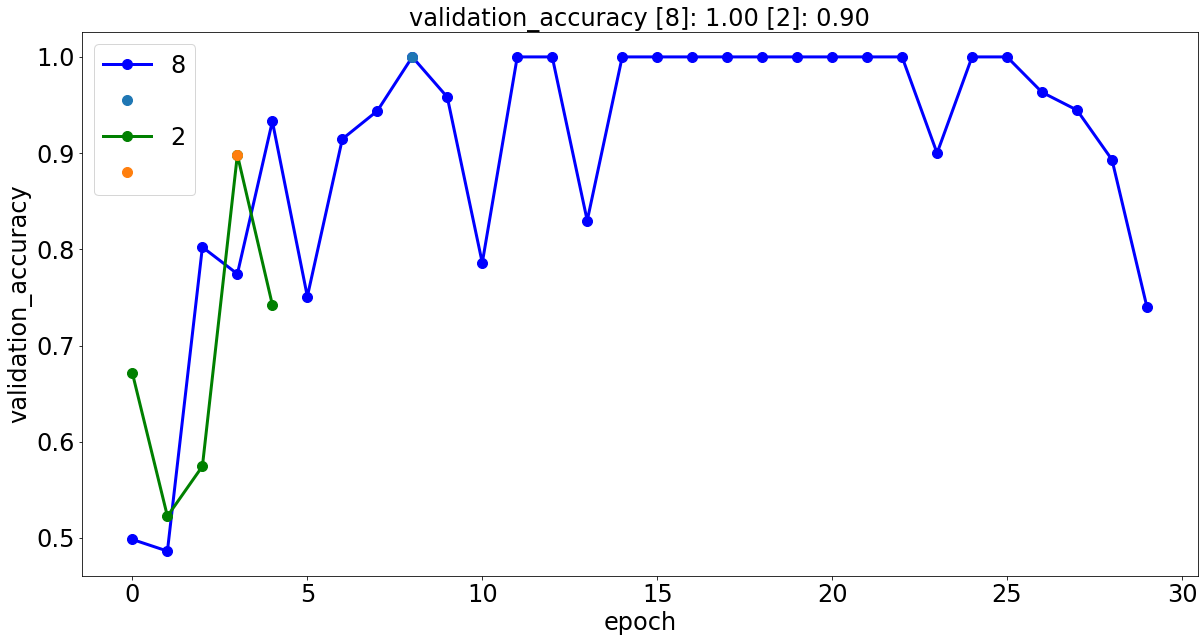

,epochs,test_accuracy,validation_accuracy
8,30.0,1.000000,1.000000
2,5.0,0.855533,0.898201


In [ ]:
metric_visualization (experiments=[-1,-2], metric=['test_accuracy', 'validation_accuracy'], backend='matplotlib')

In [ ]:
#hide
from nbdev.export import *
notebook2script(recursive=True)

Converted hpconfig.ipynb.
Converted manager_factory.ipynb.
Converted complex_dummy_experiment_manager.ipynb.
Converted dummy_experiment_manager.ipynb.
Converted example_experiment.ipynb.
Converted example_experiment_manager.ipynb.
Converted experiment_manager.ipynb.
Converted index.ipynb.
Converted change_manager.ipynb.
Converted metric_visualization.ipynb.
Converted print_parameters.ipynb.
Converted print_table.ipynb.
Converted query.ipynb.
Converted remove_experiments.ipynb.
Converted experiment_utils.ipynb.
Converted organize_experiments.ipynb.
Converted resume_from_checkpoint.ipynb.
Converted experiment_visualization.ipynb.
Converted plot_utils.ipynb.
